# A) Full Multi-Point Feature Model

n = 1
n = 2
n = 3
n = 4
n = 5

==== Full Multi-Point Feature Model (Test Set) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          66  0.9248   0.6301  1.8981   4.7229  1.1188    0.8039   
1         2          66  0.6371   0.5224  0.9304   2.3526  0.7241    0.6372   
2         3          66  0.6168   0.5575  0.9073   3.0391  0.6970    0.6492   
3         4          65  0.5005   0.4430  0.5412   1.0665  0.5593    0.4779   
4         5          65  0.4393   0.3290  0.3768   0.5155  0.4890    0.3710   

     Bias  
0  0.0344  
1  0.0251  
2  0.0091  
3  0.0437  
4  0.0411  

==== Full Multi-Point Feature Model (Validation Set) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          66  1.1454   0.9526  3.3107   5.4540  1.4224    1.1347   
1         2          66  1.3197   1.2218  4.3571   8.0449  1.5267    1.4235   
2         3          66  1.5895   1.5912  5.7747  10.5840  1.7080    1.6

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3507/307294319.py:174: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


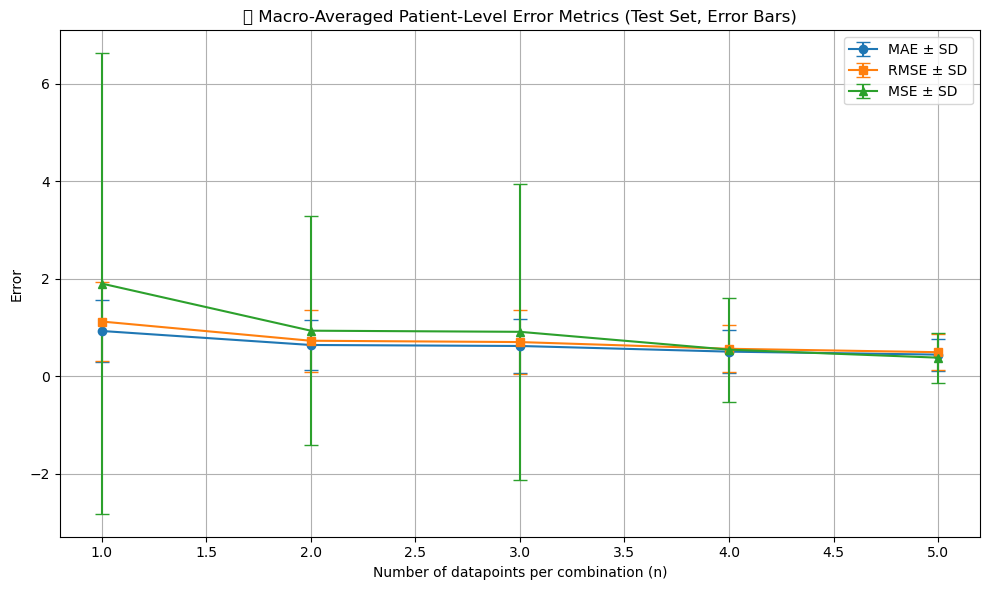

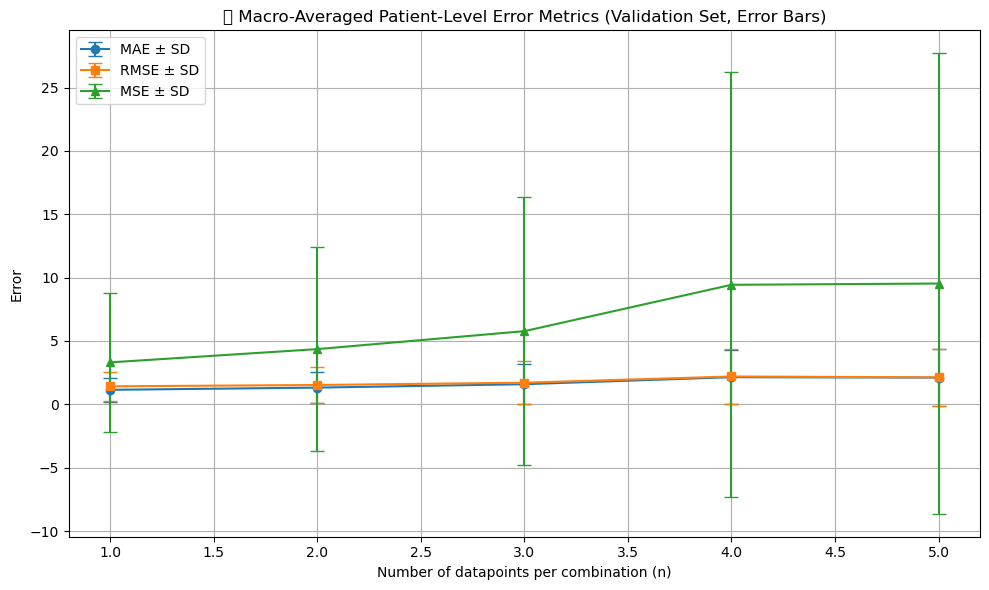

In [29]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# --- Paths ---
ODC_PATH   = Path("/Users/sarah/ML/master_thesis/ODC/Neonatal_ODC_Table.csv")
TRAIN_PATH = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/train_219_with_shift_shunt.csv")
TEST_PATH  = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/test_219_with_shift_shunt.csv")
VAL_PATH   = Path("/Users/sarah/ML/master_thesis/2-Point Combination Datasets/validation set/validation_set_shift_shunt.csv")

# --- Load data ---
odc = pd.read_csv(ODC_PATH).sort_values('SO2 (%)').drop_duplicates('SO2 (%)')
train_df = pd.read_csv(TRAIN_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
test_df  = pd.read_csv(TEST_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
val_df   = pd.read_csv(VAL_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})

# --- Preprocess ---
for df in (train_df, test_df, val_df):
    df['log_PiO2'] = np.log(df['Insp.O2(kPa)'])
    df.dropna(subset=['SpO2(%)', 'Insp.O2(kPa)', 'shift'], inplace=True)
    df = df[df['SpO2(%)'] < 95]

spo2_to_po2 = PchipInterpolator(odc['SO2 (%)'], odc['PO2 (kPa)'])
to_PcO2 = lambda spo2: spo2_to_po2(np.asarray(spo2))

def compute_shift_raw(row):
    Pc = to_PcO2([row['SpO2(%)']])[0]
    return row['Insp.O2(kPa)'] - Pc

for df in (train_df, test_df, val_df):
    df['shift_raw'] = df.apply(compute_shift_raw, axis=1)

def make_full_multi_point_features(df, n=3, max_combos=3, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        if n == 1:
            combos = [(i,) for i in range(len(group))]
        else:
            all_combos = list(combinations(range(len(group)), n))
            if len(all_combos) > max_combos:
                combos = rng.sample(all_combos, max_combos)
            else:
                combos = all_combos
        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)
            row = {'Patient_ID': pid}
            for i in range(n):
                row[f'log_PiO2_{i+1}'] = points.loc[i, 'log_PiO2']
                row[f'SpO2_{i+1}']     = points.loc[i, 'SpO2(%)']
                row[f'shift_raw_{i+1}'] = points.loc[i, 'shift_raw']
            # Summary feature: joint_shift_raw
            pcs = to_PcO2(points['SpO2(%)'].values)
            row['joint_shift_raw'] = np.mean(points['Insp.O2(kPa)'].values - pcs)
            # Target: mean shift for the combination (for n=1, just itself)
            row['shift'] = points['shift'].mean()
            records.append(row)
    return pd.DataFrame(records)

def evaluate_macro_patient_level(model, features, df):
    df = df.copy()
    X = df[features].values
    y_pred = model.predict(X)
    df['y_pred'] = y_pred
    per_patient_mae, per_patient_mse, per_patient_rmse, per_patient_bias = [], [], [], []
    for pid, group in df.groupby('Patient_ID'):
        y_true = group['shift'].values
        y_pred = group['y_pred'].values
        if len(y_true) > 0:
            per_patient_mae.append(mean_absolute_error(y_true, y_pred))
            per_patient_mse.append(mean_squared_error(y_true, y_pred))
            per_patient_rmse.append(np.sqrt(mean_squared_error(y_true, y_pred)))
            per_patient_bias.append(np.mean(y_pred - y_true))
    macro_mae = np.mean(per_patient_mae)
    macro_mae_std = np.std(per_patient_mae)
    macro_mse = np.mean(per_patient_mse)
    macro_mse_std = np.std(per_patient_mse)
    macro_rmse = np.mean(per_patient_rmse)
    macro_rmse_std = np.std(per_patient_rmse)
    macro_bias = np.mean(per_patient_bias)
    return macro_mae, macro_mae_std, macro_mse, macro_mse_std, macro_rmse, macro_rmse_std, macro_bias, len(per_patient_mae)

max_n = 5  
max_combos = 3
seed = 42
results_test = []
results_val = []

for n in range(1, max_n+1):  
    print(f"n = {n}")
    train_features = make_full_multi_point_features(train_df, n=n, max_combos=max_combos, seed=seed)
    test_features  = make_full_multi_point_features(test_df,  n=n, max_combos=max_combos, seed=seed)
    val_features   = make_full_multi_point_features(val_df,   n=n, max_combos=max_combos, seed=seed)
    if len(train_features) == 0 or len(test_features) == 0 or len(val_features) == 0:
        print(f"  Not enough data for n = {n}. Skipping.")
        continue
    # Feature columns
    feat_cols = []
    for i in range(n):
        feat_cols.append(f'log_PiO2_{i+1}')
        feat_cols.append(f'SpO2_{i+1}')
        feat_cols.append(f'shift_raw_{i+1}')
    feat_cols.append('joint_shift_raw')
    X_train = train_features[feat_cols].values
    y_train = train_features['shift'].values
    model = LinearRegression().fit(X_train, y_train)

   # Test
    (macro_mae_t, macro_mae_std_t,
    macro_mse_t, macro_mse_std_t,
    macro_rmse_t, macro_rmse_std_t,
    macro_bias_t, N_patients_t) = evaluate_macro_patient_level(model, feat_cols, test_features)

    # Val
    (macro_mae_v, macro_mae_std_v,
    macro_mse_v, macro_mse_std_v,
    macro_rmse_v, macro_rmse_std_v,
    macro_bias_v, N_patients_v) = evaluate_macro_patient_level(model, feat_cols, val_features)

    results_test.append({
        'n_points': n,
        'N_patients': N_patients_t,
        'MAE': round(macro_mae_t, 4),
        'MAE_std': round(macro_mae_std_t, 4),
        'MSE': round(macro_mse_t, 4),
        'MSE_std': round(macro_mse_std_t, 4),
        'RMSE': round(macro_rmse_t, 4),
        'RMSE_std': round(macro_rmse_std_t, 4),
        'Bias': round(macro_bias_t, 4)
    })
    results_val.append({
        'n_points': n,
        'N_patients': N_patients_v,
        'MAE': round(macro_mae_v, 4),
        'MAE_std': round(macro_mae_std_v, 4),
        'MSE': round(macro_mse_v, 4),
        'MSE_std': round(macro_mse_std_v, 4),
        'RMSE': round(macro_rmse_v, 4),
        'RMSE_std': round(macro_rmse_std_v, 4),
        'Bias': round(macro_bias_v, 4)
    })



results_test_df = pd.DataFrame(results_test)
results_val_df  = pd.DataFrame(results_val)

print("\n==== Full Multi-Point Feature Model (Test Set) ====\n")
print(results_test_df)
print("\n==== Full Multi-Point Feature Model (Validation Set) ====\n")
print(results_val_df)

# --- Plotting (optional) ---
import matplotlib.pyplot as plt

def plot_metrics_with_error(df, title):
    plt.figure(figsize=(10,6))
    plt.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE ± SD')
    plt.errorbar(df['n_points'], df['RMSE'], yerr=df['RMSE_std'], marker='s', capsize=5, label='RMSE ± SD')
    plt.errorbar(df['n_points'], df['MSE'], yerr=df['MSE_std'], marker='^', capsize=5, label='MSE ± SD')
    plt.xlabel('Number of datapoints per combination (n)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_metrics_with_error(results_test_df, '🔎 Macro-Averaged Patient-Level Error Metrics (Test Set, Error Bars)')
plot_metrics_with_error(results_val_df,  '🔎 Macro-Averaged Patient-Level Error Metrics (Validation Set, Error Bars)')


n = 1
n = 2
n = 3
n = 4
n = 5

==== Full Multi-Point Feature Model (Test Set) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          65  0.9249   0.6349  1.9085   4.7584  1.1190    0.8101   
1         2          65  0.6324   0.4743  0.7948   1.4802  0.7148    0.5328   
2         3          65  0.6008   0.5597  0.8718   3.0610  0.6719    0.6483   
3         4          64  0.4934   0.4165  0.5185   1.0021  0.5528    0.4614   
4         5          64  0.4395   0.3603  0.3909   0.5905  0.4855    0.3939   

     Bias  
0  0.0434  
1  0.0890  
2  0.0309  
3  0.0474  
4  0.0337  

==== Full Multi-Point Feature Model (Validation Set) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          66  1.1454   0.9526  3.3107   5.4540  1.4224    1.1347   
1         2          66  1.3197   1.2218  4.3571   8.0449  1.5267    1.4235   
2         3          66  1.5895   1.5912  5.7747  10.5840  1.7080    1.6

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3507/2397479766.py:175: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


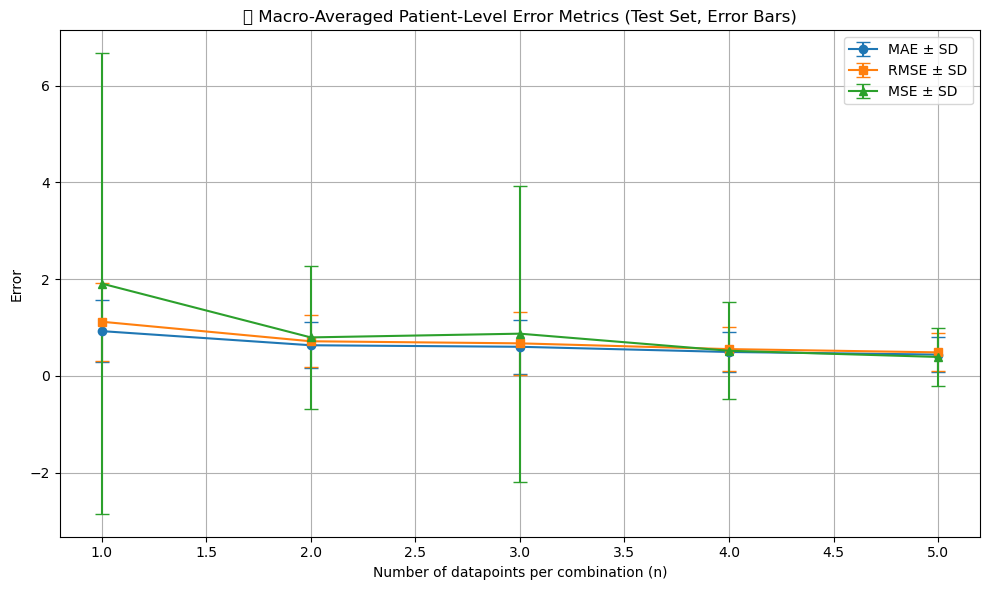

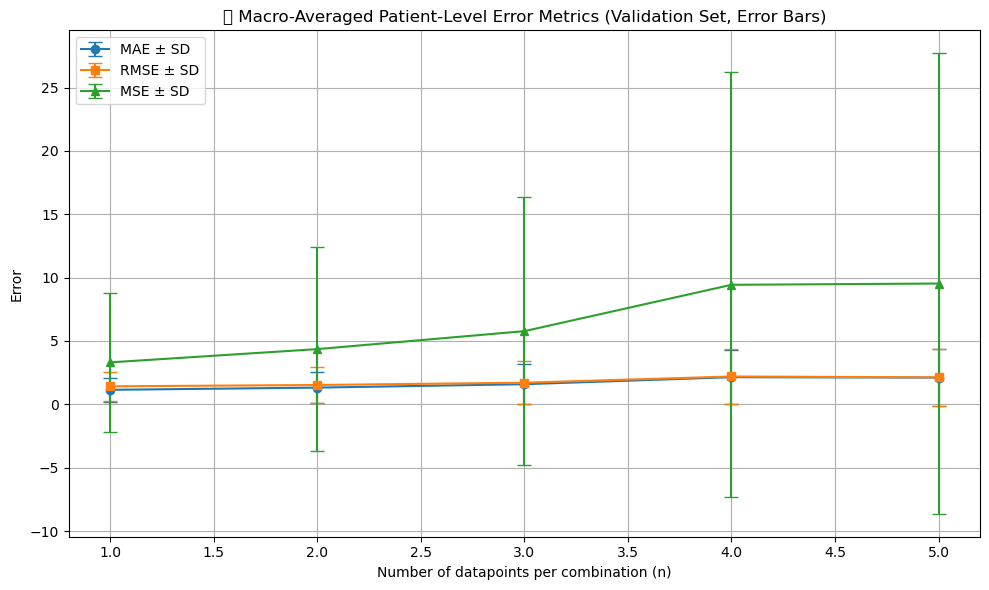

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# --- Paths ---
ODC_PATH   = Path("/Users/sarah/ML/master_thesis/ODC/Neonatal_ODC_Table.csv")
TRAIN_PATH = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/train_219_with_shift_shunt.csv")
TEST_PATH  = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/test_219_with_shift_shunt.csv")
VAL_PATH   = Path("/Users/sarah/ML/master_thesis/2-Point Combination Datasets/validation set/validation_set_shift_shunt.csv")

# --- Load data ---
odc = pd.read_csv(ODC_PATH).sort_values('SO2 (%)').drop_duplicates('SO2 (%)')
train_df = pd.read_csv(TRAIN_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
test_df  = pd.read_csv(TEST_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
val_df   = pd.read_csv(VAL_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})

# --- Preprocess ---
for df in (train_df, test_df, val_df):
    df['log_PiO2'] = np.log(df['Insp.O2(kPa)'])
    df.dropna(subset=['SpO2(%)', 'Insp.O2(kPa)', 'shift'], inplace=True)
    df = df[df['SpO2(%)'] < 95]

spo2_to_po2 = PchipInterpolator(odc['SO2 (%)'], odc['PO2 (kPa)'])
to_PcO2 = lambda spo2: spo2_to_po2(np.asarray(spo2))

def compute_shift_raw(row):
    Pc = to_PcO2([row['SpO2(%)']])[0]
    return row['Insp.O2(kPa)'] - Pc

for df in (train_df, test_df, val_df):
    df['shift_raw'] = df.apply(compute_shift_raw, axis=1)

def make_full_multi_point_features(df, n=3, max_combos=3, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        if n == 1:
            combos = [(i,) for i in range(len(group))]
        else:
            all_combos = list(combinations(range(len(group)), n))
            if len(all_combos) > max_combos:
                combos = rng.sample(all_combos, max_combos)
            else:
                combos = all_combos
        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)
            row = {'Patient_ID': pid}
            for i in range(n):
                row[f'log_PiO2_{i+1}'] = points.loc[i, 'log_PiO2']
                row[f'SpO2_{i+1}']     = points.loc[i, 'SpO2(%)']
                row[f'shift_raw_{i+1}'] = points.loc[i, 'shift_raw']
            # Summary feature: joint_shift_raw
            pcs = to_PcO2(points['SpO2(%)'].values)
            row['joint_shift_raw'] = np.mean(points['Insp.O2(kPa)'].values - pcs)
            # Target: mean shift for the combination (for n=1, just itself)
            row['shift'] = points['shift'].mean()
            records.append(row)
    return pd.DataFrame(records)

def evaluate_macro_patient_level(model, features, df):
    df = df.copy()
    X = df[features].values
    y_pred = model.predict(X)
    df['y_pred'] = y_pred
    per_patient_mae, per_patient_mse, per_patient_rmse, per_patient_bias = [], [], [], []
    for pid, group in df.groupby('Patient_ID'):
        y_true = group['shift'].values
        y_pred = group['y_pred'].values
        if len(y_true) > 0:
            per_patient_mae.append(mean_absolute_error(y_true, y_pred))
            per_patient_mse.append(mean_squared_error(y_true, y_pred))
            per_patient_rmse.append(np.sqrt(mean_squared_error(y_true, y_pred)))
            per_patient_bias.append(np.mean(y_pred - y_true))
    macro_mae = np.mean(per_patient_mae)
    macro_mae_std = np.std(per_patient_mae)
    macro_mse = np.mean(per_patient_mse)
    macro_mse_std = np.std(per_patient_mse)
    macro_rmse = np.mean(per_patient_rmse)
    macro_rmse_std = np.std(per_patient_rmse)
    macro_bias = np.mean(per_patient_bias)
    return macro_mae, macro_mae_std, macro_mse, macro_mse_std, macro_rmse, macro_rmse_std, macro_bias, len(per_patient_mae)

max_n = 5  
max_combos = 3
seed = 42
results_test = []
results_val = []

for n in range(1, max_n+1):  
    print(f"n = {n}")
    train_features = make_full_multi_point_features(train_df, n=n, max_combos=max_combos, seed=seed)
    test_features  = make_full_multi_point_features(test_df,  n=n, max_combos=max_combos, seed=seed)
    val_features   = make_full_multi_point_features(val_df,   n=n, max_combos=max_combos, seed=seed)
    if len(train_features) == 0 or len(test_features) == 0 or len(val_features) == 0:
        print(f"  Not enough data for n = {n}. Skipping.")
        continue
    # Feature columns
    feat_cols = []
    for i in range(n):
        feat_cols.append(f'log_PiO2_{i+1}')
        feat_cols.append(f'SpO2_{i+1}')
        feat_cols.append(f'shift_raw_{i+1}')
    feat_cols.append('joint_shift_raw')
    X_train = train_features[feat_cols].values
    y_train = train_features['shift'].values
    model = LinearRegression().fit(X_train, y_train)

   # Test
    (macro_mae_t, macro_mae_std_t,
    macro_mse_t, macro_mse_std_t,
    macro_rmse_t, macro_rmse_std_t,
    macro_bias_t, N_patients_t) = evaluate_macro_patient_level(model, feat_cols, test_features)

    # Val
    (macro_mae_v, macro_mae_std_v,
    macro_mse_v, macro_mse_std_v,
    macro_rmse_v, macro_rmse_std_v,
    macro_bias_v, N_patients_v) = evaluate_macro_patient_level(model, feat_cols, val_features)

    results_test.append({
        'n_points': n,
        'N_patients': N_patients_t,
        'MAE': round(macro_mae_t, 4),
        'MAE_std': round(macro_mae_std_t, 4),
        'MSE': round(macro_mse_t, 4),
        'MSE_std': round(macro_mse_std_t, 4),
        'RMSE': round(macro_rmse_t, 4),
        'RMSE_std': round(macro_rmse_std_t, 4),
        'Bias': round(macro_bias_t, 4)
    })
    results_val.append({
        'n_points': n,
        'N_patients': N_patients_v,
        'MAE': round(macro_mae_v, 4),
        'MAE_std': round(macro_mae_std_v, 4),
        'MSE': round(macro_mse_v, 4),
        'MSE_std': round(macro_mse_std_v, 4),
        'RMSE': round(macro_rmse_v, 4),
        'RMSE_std': round(macro_rmse_std_v, 4),
        'Bias': round(macro_bias_v, 4)
    })



results_test_df = pd.DataFrame(results_test)
results_val_df  = pd.DataFrame(results_val)

print("\n==== Full Multi-Point Feature Model (Test Set) ====\n")
print(results_test_df)
print("\n==== Full Multi-Point Feature Model (Validation Set) ====\n")
print(results_val_df)

# --- Plotting (optional) ---
import matplotlib.pyplot as plt

def plot_metrics_with_error(df, title):
    plt.figure(figsize=(10,6))
    plt.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE ± SD')
    plt.errorbar(df['n_points'], df['RMSE'], yerr=df['RMSE_std'], marker='s', capsize=5, label='RMSE ± SD')
    plt.errorbar(df['n_points'], df['MSE'], yerr=df['MSE_std'], marker='^', capsize=5, label='MSE ± SD')
    plt.xlabel('Number of datapoints per combination (n)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_metrics_with_error(results_test_df, '🔎 Macro-Averaged Patient-Level Error Metrics (Test Set, Error Bars)')
plot_metrics_with_error(results_val_df,  '🔎 Macro-Averaged Patient-Level Error Metrics (Validation Set, Error Bars)')


In [3]:
results_full = results_test_df.copy()
results_full_val = results_val_df.copy()

# B) multi-point raw shift model 

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# --- Paths ---
ODC_PATH   = Path("/Users/sarah/ML/master_thesis/ODC/Neonatal_ODC_Table.csv")
TRAIN_PATH = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/train_219_with_shift_shunt.csv")
TEST_PATH  = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/test_219_with_shift_shunt.csv")
VAL_PATH   = Path("/Users/sarah/ML/master_thesis/2-Point Combination Datasets/validation set/validation_set_shift_shunt.csv")  # <--- Your validation set

# --- Load data ---
odc = pd.read_csv(ODC_PATH).sort_values('SO2 (%)').drop_duplicates('SO2 (%)')
train_df = pd.read_csv(TRAIN_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
test_df  = pd.read_csv(TEST_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
val_df   = pd.read_csv(VAL_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})

# --- Preprocess ---
for df in (train_df, test_df, val_df):
    df['log_PiO2'] = np.log(df['Insp.O2(kPa)'])
    df.dropna(subset=['SpO2(%)', 'Insp.O2(kPa)', 'shift'], inplace=True)
    df = df[df['SpO2(%)'] < 95]

spo2_to_po2 = PchipInterpolator(odc['SO2 (%)'], odc['PO2 (kPa)'])
to_PcO2 = lambda spo2: spo2_to_po2(np.asarray(spo2))

def compute_shift_raw(row):
    Pc = to_PcO2([row['SpO2(%)']])[0]
    return row['Insp.O2(kPa)'] - Pc

for df in (train_df, test_df, val_df):
    df['shift_raw'] = df.apply(compute_shift_raw, axis=1)

def make_custom_feature_rows(df, n=3, max_combos=3, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        all_combos = list(combinations(range(len(group)), n))
        if len(all_combos) > max_combos:
            combos = rng.sample(all_combos, max_combos)
        else:
            combos = all_combos
        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)]
            pcs = to_PcO2(points['SpO2(%)'].values)
            joint_shift = np.mean(points['Insp.O2(kPa)'].values - pcs)
            # Find the point with the lowest SpO2 in this combination
            min_spo2_idx = points['SpO2(%)'].idxmin()
            min_point = points.loc[min_spo2_idx]
            log_PiO2 = min_point['log_PiO2']
            SpO2 = min_point['SpO2(%)']
            row = {
                'Patient_ID': pid,
                'joint_shift': joint_shift,
                'log_PiO2': log_PiO2,
                'SpO2': SpO2,
                'shift': points['shift'].mean()  # Or min_point['shift'] if preferred
            }
            records.append(row)
    return pd.DataFrame(records)

def evaluate_on_df(model, features, df):
    df = df.copy()
    X = df[features].values
    y_pred = model.predict(X)
    df['y_pred'] = y_pred
    per_patient_mae, per_patient_mse, per_patient_rmse, per_patient_bias = [], [], [], []
    for pid, group in df.groupby('Patient_ID'):
        y_true = group['shift'].values
        y_pred = group['y_pred'].values
        if len(y_true) > 0:
            per_patient_mae.append(mean_absolute_error(y_true, y_pred))
            mse = mean_squared_error(y_true, y_pred)
            per_patient_mse.append(mse)
            per_patient_rmse.append(np.sqrt(mse))
            per_patient_bias.append(np.mean(y_pred - y_true))
    macro_mae = np.mean(per_patient_mae)
    macro_mae_std = np.std(per_patient_mae)
    macro_mse = np.mean(per_patient_mse)
    macro_mse_std = np.std(per_patient_mse)
    macro_rmse = np.mean(per_patient_rmse)
    macro_rmse_std = np.std(per_patient_rmse)
    macro_bias = np.mean(per_patient_bias)
    return macro_mae, macro_mae_std, macro_mse, macro_mse_std, macro_rmse, macro_rmse_std, macro_bias, len(per_patient_mae)


max_n = 5
max_combos = 3
seed = 42
results = []

for n in range(2, max_n+1):
    print(f"n = {n}")
    train_agg = make_custom_feature_rows(train_df, n=n, max_combos=max_combos, seed=seed)
    test_agg  = make_custom_feature_rows(test_df,  n=n, max_combos=max_combos, seed=seed)
    val_agg   = make_custom_feature_rows(val_df,   n=n, max_combos=max_combos, seed=seed)
    if len(train_agg) == 0 or len(test_agg) == 0 or len(val_agg) == 0:
        print(f"  Not enough data for n = {n}. Skipping.")
        continue
    features = ['joint_shift', 'log_PiO2', 'SpO2']
    X_train = train_agg[features].values
    y_train = train_agg['shift'].values

    model = LinearRegression().fit(X_train, y_train)

    # Test set
    (macro_mae_t, macro_mae_std_t, macro_mse_t, macro_mse_std_t,
     macro_rmse_t, macro_rmse_std_t, macro_bias_t, N_patients_t) = evaluate_on_df(model, features, test_agg)
    # Validation set
    (macro_mae_v, macro_mae_std_v, macro_mse_v, macro_mse_std_v,
     macro_rmse_v, macro_rmse_std_v, macro_bias_v, N_patients_v) = evaluate_on_df(model, features, val_agg)

    results.append({
        'n_points': n,
        'N_patients_test': N_patients_t,
        'MAE_test': round(macro_mae_t, 4),
        'MAE_std_test': round(macro_mae_std_t, 4),
        'MSE_test': round(macro_mse_t, 4),
        'MSE_std_test': round(macro_mse_std_t, 4),
        'RMSE_test': round(macro_rmse_t, 4),
        'RMSE_std_test': round(macro_rmse_std_t, 4),
        'Bias_test': round(macro_bias_t, 4),
        'N_patients_val': N_patients_v,
        'MAE_val': round(macro_mae_v, 4),
        'MAE_std_val': round(macro_mae_std_v, 4),
        'MSE_val': round(macro_mse_v, 4),
        'MSE_std_val': round(macro_mse_std_v, 4),
        'RMSE_val': round(macro_rmse_v, 4),
        'RMSE_std_val': round(macro_rmse_std_v, 4),
        'Bias_val': round(macro_bias_v, 4)
    })

results_df = pd.DataFrame(results)
print("\n🔎 Macro-Averaged Patient-Level Metrics (Multi-point shift_raw summary model):\n")
print(results_df)


n = 2
n = 3
n = 4
n = 5

🔎 Macro-Averaged Patient-Level Metrics (Multi-point shift_raw summary model):

   n_points  N_patients_test  MAE_test  MAE_std_test  MSE_test  MSE_std_test  \
0         2               66    0.7009        0.6115    1.1491        2.7309   
1         3               66    0.6893        0.6126    1.0374        3.0100   
2         4               65    0.6225        0.5871    0.8098        2.1580   
3         5               65    0.5912        0.4683    0.6208        1.1197   

   RMSE_test  RMSE_std_test  Bias_test  N_patients_val  MAE_val  MAE_std_val  \
0     0.8048         0.7081     0.0860              66   0.9689       0.9074   
1     0.7717         0.6647     0.0717              66   0.7570       0.7578   
2     0.6643         0.6070     0.1255              56   0.7308       0.6672   
3     0.6211         0.4847     0.1436              29   0.8465       0.6248   

   MSE_val  MSE_std_val  RMSE_val  RMSE_std_val  Bias_val  
0   2.2501       4.1876    1.1098 

In [17]:
features_sp = ['log_PiO2', 'SpO2(%)', 'shift_raw']

In [18]:
def get_single_point_macro_metrics(train_df, test_df, val_df):
    # Train model on train set
    X_train = train_df[features_sp].values
    y_train = train_df['shift'].values
    X_test  = test_df[features_sp].values
    y_test  = test_df['shift'].values
    X_val   = val_df[features_sp].values
    y_val   = val_df['shift'].values

    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X_train, y_train)

    def macro_metrics(df, X, model):
        df = df.copy()
        df['y_pred'] = model.predict(X)
        per_patient_mae, per_patient_mse, per_patient_bias = [], [], []
        for pid, group in df.groupby('Patient_ID'):
            y_true = group['shift'].values
            y_pred = group['y_pred'].values
            if len(y_true) > 0:
                per_patient_mae.append(mean_absolute_error(y_true, y_pred))
                per_patient_mse.append(mean_squared_error(y_true, y_pred))
                per_patient_bias.append(np.mean(y_pred - y_true))
        macro_mae = np.mean(per_patient_mae)
        macro_mae_std = np.std(per_patient_mae)       # <--- SD for error bar!
        macro_mse = np.mean(per_patient_mse)
        macro_rmse = np.mean(np.sqrt(per_patient_mse))
        macro_bias = np.mean(per_patient_bias)
        return macro_mae, macro_mae_std, macro_mse, macro_rmse, macro_bias, len(per_patient_mae)

    # Compute for test and val
    macro_mae_t, macro_mae_std_t, macro_mse_t, macro_rmse_t, macro_bias_t, N_patients_t = macro_metrics(test_df, X_test, model)
    macro_mae_v, macro_mae_std_v, macro_mse_v, macro_rmse_v, macro_bias_v, N_patients_v = macro_metrics(val_df, X_val, model)

    return {
        'n_points': 1,
        'N_patients_test': N_patients_t,
        'MAE_test': round(macro_mae_t, 4),
        'MAE_std_test': round(macro_mae_std_t, 4),      # <--- Now included!
        'MSE_test': round(macro_mse_t, 4),
        'RMSE_test': round(macro_rmse_t, 4),
        'Bias_test': round(macro_bias_t, 4),
        'N_patients_val': N_patients_v,
        'MAE_val': round(macro_mae_v, 4),
        'MAE_std_val': round(macro_mae_std_v, 4),        # <--- Now included!
        'MSE_val': round(macro_mse_v, 4),
        'RMSE_val': round(macro_rmse_v, 4),
        'Bias_val': round(macro_bias_v, 4)
    }


In [19]:
single_point_result = get_single_point_macro_metrics(train_df, test_df, val_df)
results_df = pd.concat([pd.DataFrame([single_point_result]), results_df], ignore_index=True).sort_values('n_points')


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3507/4188990313.py:21: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


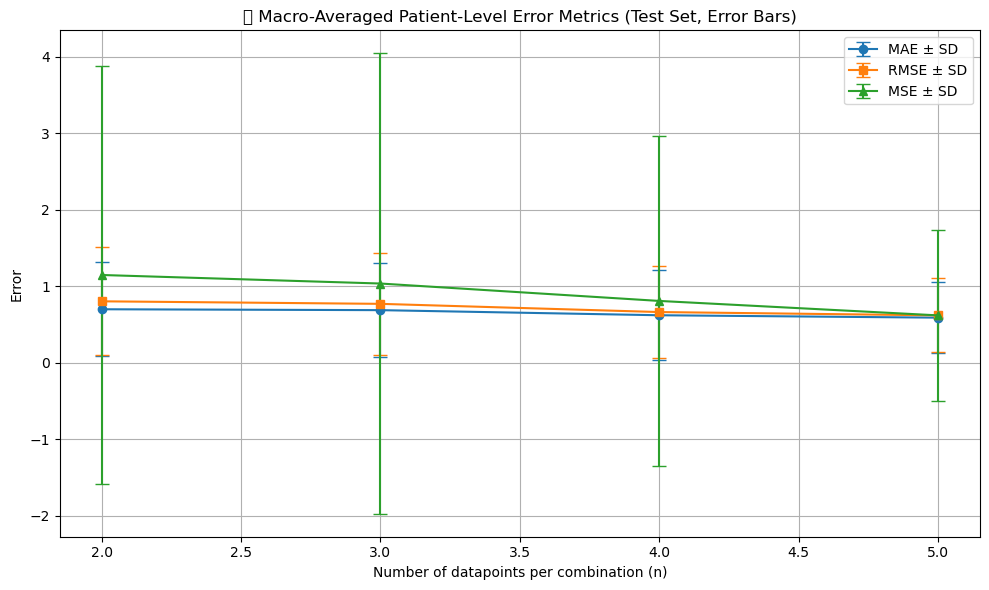

In [31]:
import matplotlib.pyplot as plt

test_metrics = results_df[['n_points', 'MAE_test', 'MAE_std_test',
                           'MSE_test', 'MSE_std_test',
                           'RMSE_test', 'RMSE_std_test']].rename(
    columns={'MAE_test': 'MAE', 'MAE_std_test': 'MAE_std',
             'MSE_test': 'MSE', 'MSE_std_test': 'MSE_std',
             'RMSE_test': 'RMSE', 'RMSE_std_test': 'RMSE_std'}
)

def plot_metrics_with_error(df, title):
    plt.figure(figsize=(10,6))
    plt.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE ± SD')
    plt.errorbar(df['n_points'], df['RMSE'], yerr=df['RMSE_std'], marker='s', capsize=5, label='RMSE ± SD')
    plt.errorbar(df['n_points'], df['MSE'], yerr=df['MSE_std'], marker='^', capsize=5, label='MSE ± SD')
    plt.xlabel('Number of datapoints per combination (n)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics_with_error(test_metrics, '🔎 Macro-Averaged Patient-Level Error Metrics (Test Set, Error Bars)')


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3507/3182875391.py:21: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


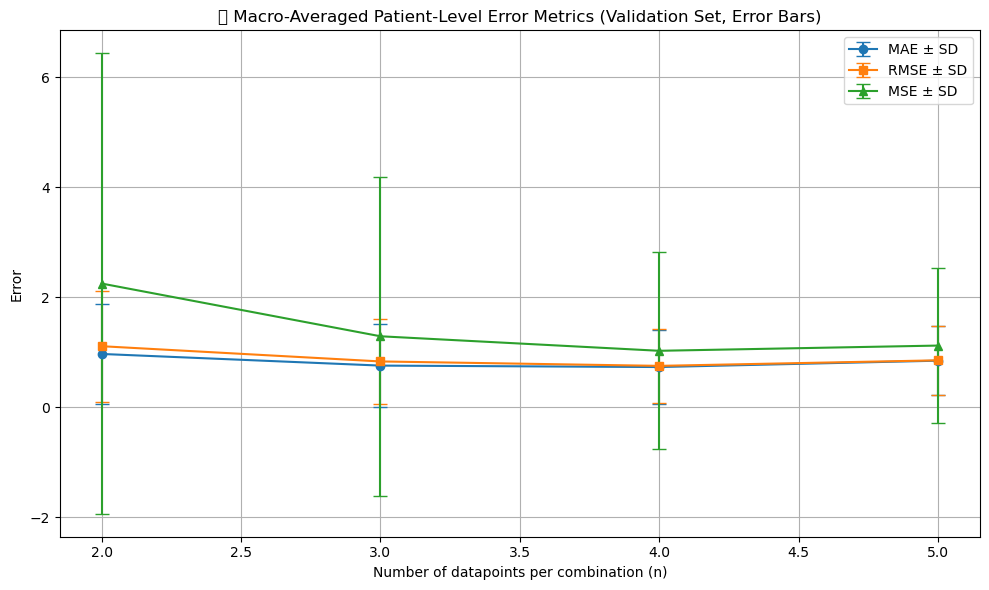

In [33]:
import matplotlib.pyplot as plt

val_metrics = results_df[['n_points', 'MAE_val', 'MAE_std_val',
                           'MSE_val', 'MSE_std_val',
                           'RMSE_val', 'RMSE_std_val']].rename(
    columns={'MAE_val': 'MAE', 'MAE_std_val': 'MAE_std',
             'MSE_val': 'MSE', 'MSE_std_val': 'MSE_std',
             'RMSE_val': 'RMSE', 'RMSE_std_val': 'RMSE_std'}
)

def plot_metrics_with_error(df, title):
    plt.figure(figsize=(10,6))
    plt.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE ± SD')
    plt.errorbar(df['n_points'], df['RMSE'], yerr=df['RMSE_std'], marker='s', capsize=5, label='RMSE ± SD')
    plt.errorbar(df['n_points'], df['MSE'], yerr=df['MSE_std'], marker='^', capsize=5, label='MSE ± SD')
    plt.xlabel('Number of datapoints per combination (n)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metrics_with_error(val_metrics, '🔎 Macro-Averaged Patient-Level Error Metrics (Validation Set, Error Bars)')


In [21]:
results_raw = test_metrics.copy()
results_raw_val = val_metrics.copy()

# C) Single-Point Model


==== Averaged Single-Point Predictions (Test Set, Macro-Averaged Patient-Level Metrics) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          66  0.9248   0.6301  1.8981   4.7229  1.1188    0.8039   
1         2          66  0.8934   0.5528  1.6659   3.2033  1.0751    0.7142   
2         3          66  0.8726   0.4977  1.5877   3.3742  1.0630    0.6766   
3         4          65  0.9372   0.6858  1.9594   5.1732  1.1168    0.8438   
4         5          65  0.9032   0.5645  1.7667   4.1909  1.0966    0.7511   

     Bias  
0  0.0344  
1  0.0206  
2  0.0259  
3  0.0417  
4  0.0350  

==== Averaged Single-Point Predictions (Validation Set, Macro-Averaged Patient-Level Metrics) ====

   n_points  N_patients     MAE  MAE_std     MSE  MSE_std    RMSE  RMSE_std  \
0         1          66  1.1454   0.9526  3.3107   5.4540  1.4224    1.1347   
1         2          66  1.1929   1.0074  3.4590   5.4414  1.4528    1.1612   
2         3         

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3507/135983589.py:181: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


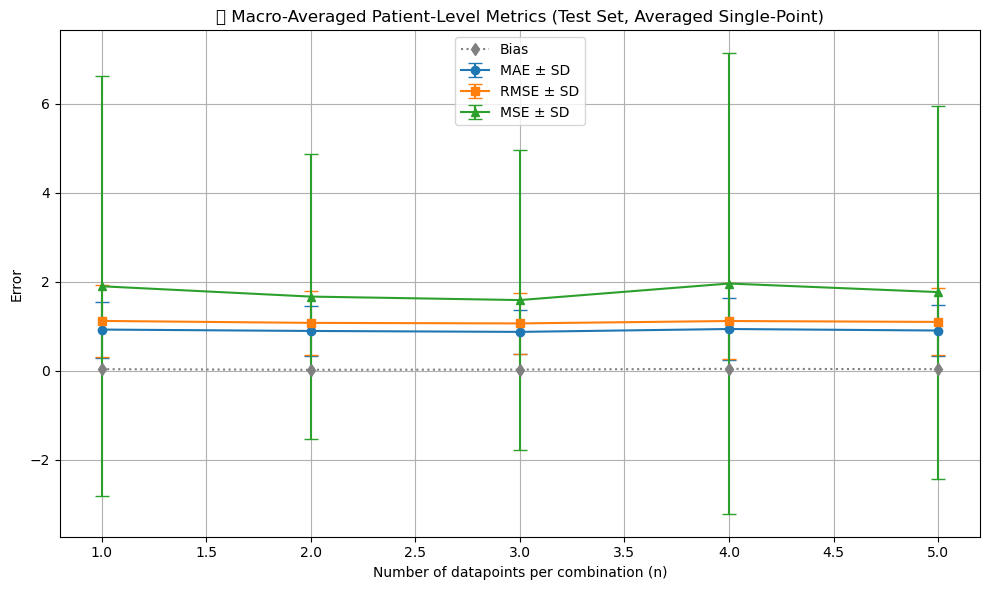

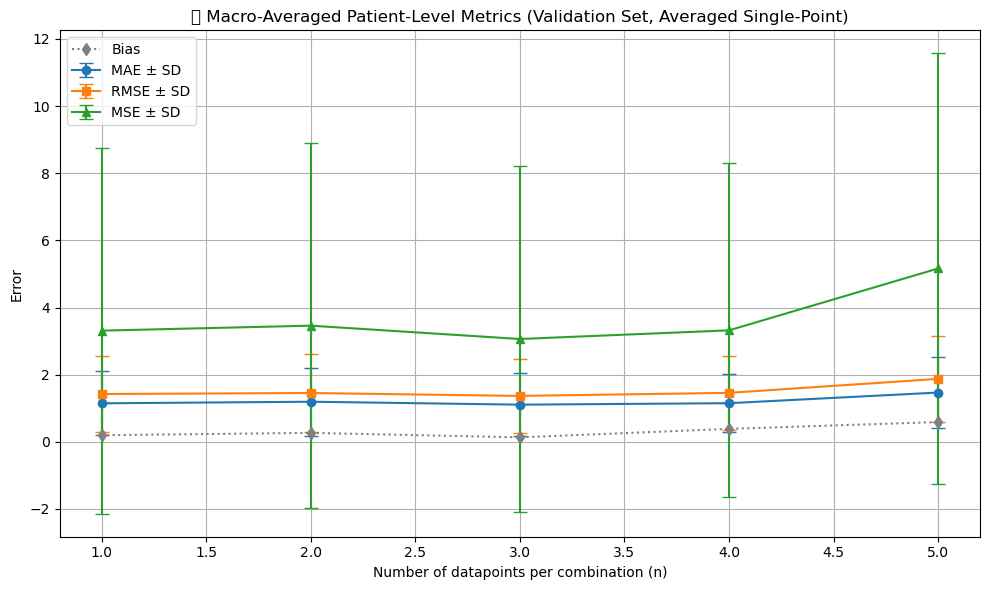

In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# --- Paths ---
ODC_PATH   = Path("/Users/sarah/ML/master_thesis/ODC/Neonatal_ODC_Table.csv")
TRAIN_PATH = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/train_219_with_shift_shunt.csv")
TEST_PATH  = Path("/Users/sarah/ML/master_thesis/Datasets/Shift Calculation/test_219_with_shift_shunt.csv")
VAL_PATH   = Path("/Users/sarah/ML/master_thesis/2-Point Combination Datasets/validation set/validation_set_shift_shunt.csv")

# --- Load data ---
odc = pd.read_csv(ODC_PATH).sort_values('SO2 (%)').drop_duplicates('SO2 (%)')
train_df = pd.read_csv(TRAIN_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
test_df  = pd.read_csv(TEST_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})
val_df   = pd.read_csv(VAL_PATH).rename(columns={'Anon.Patient_ID': 'Patient_ID'})

# --- Preprocess ---
for df in (train_df, test_df, val_df):
    df['log_PiO2'] = np.log(df['Insp.O2(kPa)'])
    df.dropna(subset=['SpO2(%)', 'Insp.O2(kPa)', 'shift'], inplace=True)
    df = df[df['SpO2(%)'] < 95]

spo2_to_po2 = PchipInterpolator(odc['SO2 (%)'], odc['PO2 (kPa)'])
to_PcO2 = lambda spo2: spo2_to_po2(np.asarray(spo2))

def compute_shift_raw(row):
    Pc = to_PcO2([row['SpO2(%)']])[0]
    return row['Insp.O2(kPa)'] - Pc

for df in (train_df, test_df, val_df):
    df['shift_raw'] = df.apply(compute_shift_raw, axis=1)

features = ['shift_raw', 'log_PiO2', 'SpO2(%)']
max_n = 5
max_combos = 3
seed = 42

# --- Train model ONCE on all train points ---
X_train = train_df[features].values
y_train = train_df['shift'].values
model = LinearRegression().fit(X_train, y_train)

def evaluate_averaged_single_point_macro(df, model, features, max_n=5, max_combos=3, seed=42):
    results = []
    rng = random.Random(seed)
    # n=1 (single point): treat each point as its own combo
    combo_preds = []
    for pid, group in df.groupby('Patient_ID'):
        group = group.reset_index(drop=True)
        for i in range(len(group)):
            points = group.loc[[i]]
            X = points[features].values
            y_true = points['shift'].values
            y_pred = model.predict(X)
            combo_preds.append({
                'Patient_ID': pid,
                'y_true': y_true[0],
                'y_pred': y_pred[0]
            })
    combo_df = pd.DataFrame(combo_preds)
    # Macro-averaged patient-level metrics for n=1
        # Macro-averaged patient-level metrics for n=1
    per_patient_mae, per_patient_mse, per_patient_rmse, per_patient_bias = [], [], [], []
    for pid, group in combo_df.groupby('Patient_ID'):
        y_true = group['y_true'].values
        y_pred = group['y_pred'].values
        if len(y_true) > 0:
            per_patient_mae.append(mean_absolute_error(y_true, y_pred))
            mse = mean_squared_error(y_true, y_pred)
            per_patient_mse.append(mse)
            per_patient_rmse.append(np.sqrt(mse))
            per_patient_bias.append(np.mean(y_pred - y_true))
    mae = np.mean(per_patient_mae)
    mae_std = np.std(per_patient_mae)
    mse = np.mean(per_patient_mse)
    mse_std = np.std(per_patient_mse)
    rmse = np.mean(per_patient_rmse)
    rmse_std = np.std(per_patient_rmse)
    bias = np.mean(per_patient_bias)
    results.append({
        'n_points': 1,
        'N_patients': len(per_patient_mae),
        'MAE': round(mae, 4),
        'MAE_std': round(mae_std, 4),
        'MSE': round(mse, 4),
        'MSE_std': round(mse_std, 4),
        'RMSE': round(rmse, 4),
        'RMSE_std': round(rmse_std, 4),
        'Bias': round(bias, 4)
    })


    # n=2,3,...,max_n
    for n in range(2, max_n+1):
        combo_preds = []
        for pid, group in df.groupby('Patient_ID'):
            group = group.reset_index(drop=True)
            if len(group) < n:
                continue
            all_combos = list(combinations(range(len(group)), n))
            if len(all_combos) > max_combos:
                combos = rng.sample(all_combos, max_combos)
            else:
                combos = all_combos
            for idx_tuple in combos:
                points = group.loc[list(idx_tuple)]
                X = points[features].values
                y_true = points['shift'].values
                y_pred = model.predict(X)
                for yt, yp in zip(y_true, y_pred):  # <-- Note: use ALL predictions
                    combo_preds.append({
                        'Patient_ID': pid,
                        'y_true': yt,
                        'y_pred': yp
                    })
        if len(combo_preds) == 0:
            print(f"  Not enough data for n = {n}. Skipping.")
            continue
        combo_df = pd.DataFrame(combo_preds)
        # Macro-averaged patient-level metrics
                # Macro-averaged patient-level metrics
        per_patient_mae, per_patient_mse, per_patient_rmse, per_patient_bias = [], [], [], []
        for pid, group in combo_df.groupby('Patient_ID'):
            y_true = group['y_true'].values
            y_pred = group['y_pred'].values
            if len(y_true) > 0:
                per_patient_mae.append(mean_absolute_error(y_true, y_pred))
                mse = mean_squared_error(y_true, y_pred)
                per_patient_mse.append(mse)
                per_patient_rmse.append(np.sqrt(mse))
                per_patient_bias.append(np.mean(y_pred - y_true))
        mae = np.mean(per_patient_mae)
        mae_std = np.std(per_patient_mae)
        mse = np.mean(per_patient_mse)
        mse_std = np.std(per_patient_mse)
        rmse = np.mean(per_patient_rmse)
        rmse_std = np.std(per_patient_rmse)
        bias = np.mean(per_patient_bias)
        results.append({
            'n_points': n,
            'N_patients': len(per_patient_mae),
            'MAE': round(mae, 4),
            'MAE_std': round(mae_std, 4),
            'MSE': round(mse, 4),
            'MSE_std': round(mse_std, 4),
            'RMSE': round(rmse, 4),
            'RMSE_std': round(rmse_std, 4),
            'Bias': round(bias, 4)
        })

    return pd.DataFrame(results)

# --- Evaluate for both test and validation sets ---
results_test = evaluate_averaged_single_point_macro(test_df, model, features, max_n, max_combos, seed)
results_val  = evaluate_averaged_single_point_macro(val_df,  model, features, max_n, max_combos, seed)

print("\n==== Averaged Single-Point Predictions (Test Set, Macro-Averaged Patient-Level Metrics) ====\n")
print(results_test)
print("\n==== Averaged Single-Point Predictions (Validation Set, Macro-Averaged Patient-Level Metrics) ====\n")
print(results_val)

# --- Plotting ---
import matplotlib.pyplot as plt

def plot_metrics(df, title):
    plt.figure(figsize=(10,6))
    plt.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE ± SD')
    plt.errorbar(df['n_points'], df['RMSE'], yerr=df['RMSE_std'], marker='s', capsize=5, label='RMSE ± SD')
    plt.errorbar(df['n_points'], df['MSE'], yerr=df['MSE_std'], marker='^', capsize=5, label='MSE ± SD')
    plt.plot(df['n_points'], df['Bias'], marker='d', label='Bias', color='gray', linestyle=':')
    plt.xlabel('Number of datapoints per combination (n)')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_metrics(results_test, '🔎 Macro-Averaged Patient-Level Metrics (Test Set, Averaged Single-Point)')
plot_metrics(results_val,  '🔎 Macro-Averaged Patient-Level Metrics (Validation Set, Averaged Single-Point)')


In [23]:
results_single = results_test.copy()
results_single_val = results_val.copy()

# Plot

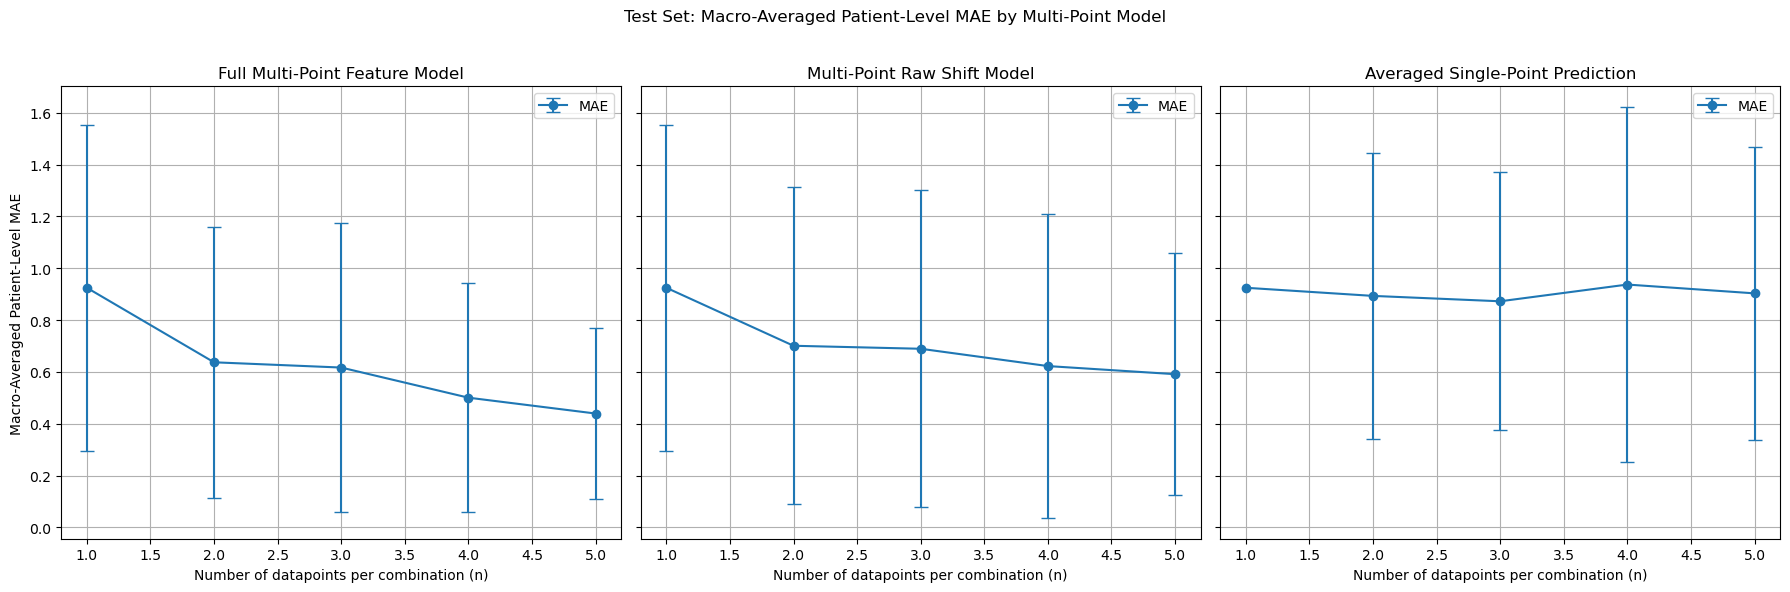

In [24]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
# results_full   = ...  # Full Multi-Point Feature Model
# results_raw    = ...  # Multi-Point Raw Shift Model
# results_single = ...  # Averaged Single-Point Prediction

# -- Make sure the DataFrames are sorted by n_points
results_full = results_full.sort_values('n_points')
results_raw = results_raw.sort_values('n_points')
results_single = results_single.sort_values('n_points')

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

models = [
    (results_full, "Full Multi-Point Feature Model"),
    (results_raw, "Multi-Point Raw Shift Model"),
    (results_single, "Averaged Single-Point Prediction")
]

for ax, (df, title) in zip(axes, models):
    ax.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE')
    ax.set_xlabel('Number of datapoints per combination (n)')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
axes[0].set_ylabel('Macro-Averaged Patient-Level MAE')
plt.suptitle('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



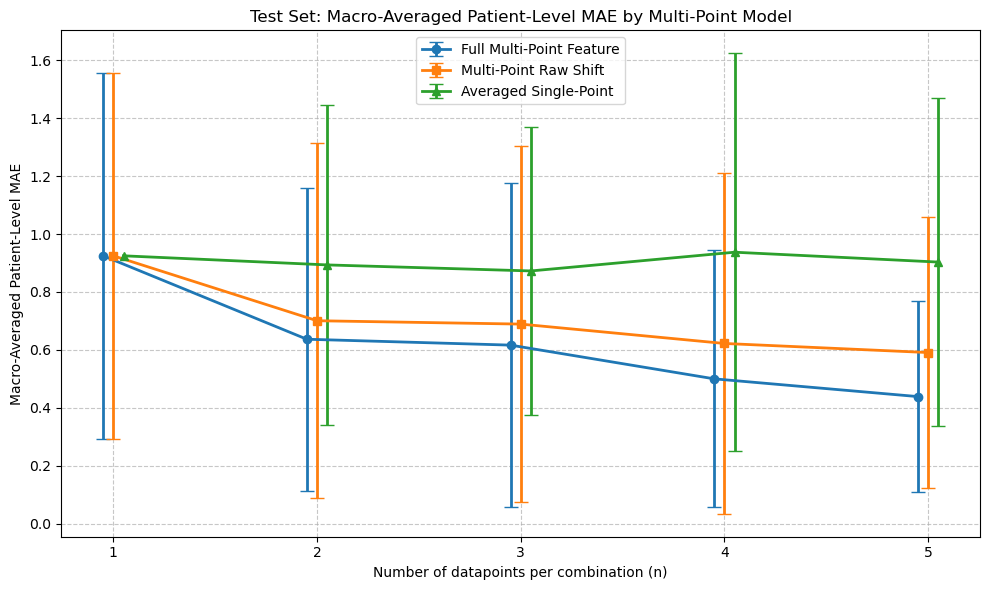

In [28]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
results_full = results_full.sort_values('n_points')
results_raw = results_raw.sort_values('n_points')
results_single = results_single.sort_values('n_points')

plt.figure(figsize=(10,6))

shift = 0.05
plt.errorbar(results_full['n_points'] - shift, results_full['MAE'], yerr=results_full['MAE_std'],
             marker='o', capsize=5, label='Full Multi-Point Feature', color='tab:blue', lw=2)
plt.errorbar(results_raw['n_points'], results_raw['MAE'], yerr=results_raw['MAE_std'],
             marker='s', capsize=5, label='Multi-Point Raw Shift', color='tab:orange', lw=2)
plt.errorbar(results_single['n_points'] + shift, results_single['MAE'], yerr=results_single['MAE_std'],
             marker='^', capsize=5, label='Averaged Single-Point', color='tab:green', lw=2)

plt.xlabel('Number of datapoints per combination (n)')
plt.ylabel('Macro-Averaged Patient-Level MAE')
plt.title('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()


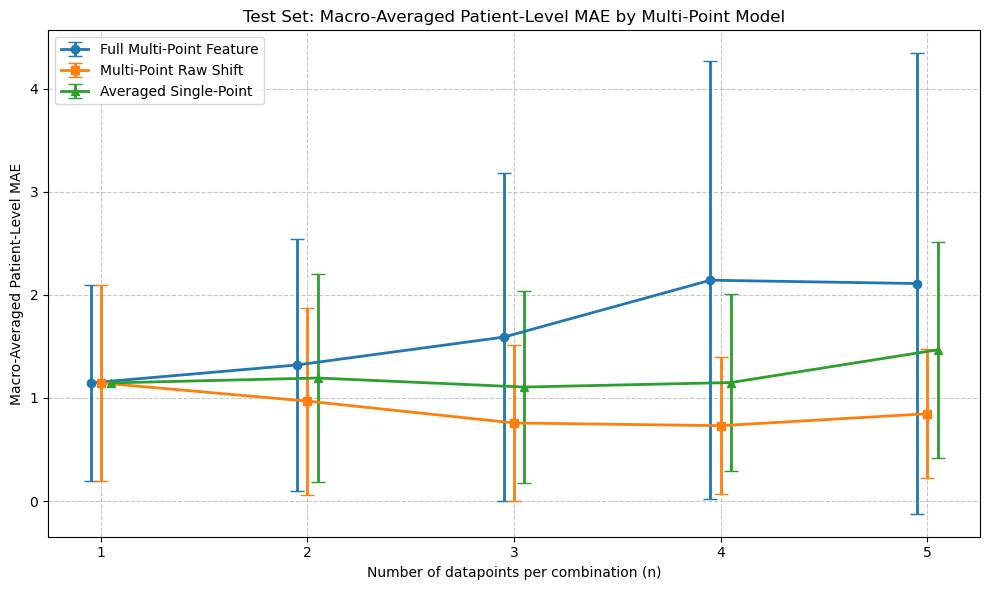

In [27]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
results_full_val = results_full_val.sort_values('n_points')
results_raw_val = results_raw_val.sort_values('n_points')
results_single_val = results_single_val.sort_values('n_points')

plt.figure(figsize=(10,6))

shift = 0.05
plt.errorbar(results_full_val['n_points'] - shift, results_full_val['MAE'], yerr=results_full_val['MAE_std'],
             marker='o', capsize=5, label='Full Multi-Point Feature', color='tab:blue', lw=2)
plt.errorbar(results_raw_val['n_points'], results_raw_val['MAE'], yerr=results_raw_val['MAE_std'],
             marker='s', capsize=5, label='Multi-Point Raw Shift', color='tab:orange', lw=2)
plt.errorbar(results_single_val['n_points'] + shift, results_single_val['MAE'], yerr=results_single_val['MAE_std'],
             marker='^', capsize=5, label='Averaged Single-Point', color='tab:green', lw=2)

plt.xlabel('Number of datapoints per combination (n)')
plt.ylabel('Macro-Averaged Patient-Level MAE')
plt.title('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()
